In [1]:
import os
import random
import torch, torchvision
import numpy as np
from src.utils import LeNet, normalize_result
import src.utils as utils
from src.shift_explainer import XPE, XPPE, AttributionXShift, LocalAttributionDifference
from src.base_explainer import KernelShap
import matplotlib.pyplot as plt
import shap
import ot


datadir = 'data/'
modeldir = 'models/'
N = 500

seed = 0
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Define setting

In [2]:
test_mnist = torchvision.datasets.MNIST(datadir, train=False, download=True, transform = torchvision.transforms.ToTensor())
test_mnist = torch.utils.data.Subset(test_mnist, np.random.choice(len(test_mnist), N, replace=False))

Xs = torch.stack([test_mnist[i][0] for i in range(N)]).numpy()
labels = np.array([test_mnist[i][1] for i in range(N)])

Xt=np.stack([utils.zigzag(Xs[i].copy()*255., severity=2, seed=1)/255. for i in range(N)])
Xt = Xt.reshape(N, -1)


cnn = LeNet()
cnn.load_state_dict(torch.load(modeldir+'LeNet'), strict=False)
cnn = cnn.eval()

def model_fn(x):
    x = x.reshape(-1, 1, 28, 28)
    x = torch.tensor(x, dtype=torch.float32)
    return cnn(x).detach().numpy()

explainer = KernelShap(model_fn)
matcher = ot.da.EMDTransport()

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.


### Identify samples where corruptions have highest and lowest impact on performance

In [3]:
def get_high_loss_samples(Xs, Xt, labels, model_fn, k=3):

    def _f_cross_entropy(model_fn, x, label):
        y = model_fn(x)
        y= (np.exp(y - np.max(y, axis=-1, keepdims=True)) / np.exp(y- np.max(y, axis=-1, keepdims=True)).sum(axis=-1, keepdims=True))
        return - np.log(y[:, label]+1e-12)
    
    losses = []
    for xs, xt, ys in zip(Xs, Xt, labels):
        loss = _f_cross_entropy(model_fn, xt, ys) - _f_cross_entropy(model_fn, xs, ys)
        losses.append(loss)

    losses = np.array(losses).flatten()
    idx = np.argsort(losses)
    idx_top = idx[-k:]
    idx_bottom = idx[:k]
    return idx_top, idx_bottom, losses


idx_top, idx_bottom, losses = get_high_loss_samples(Xs, Xt, labels, model_fn, k=10)

# shuffle source samples to avoid bias in the matching
idx_permute = np.random.permutation(N)
Xs = Xs[idx_permute].reshape(N, -1)
Ys = labels[idx_permute]

### Compute Different Shift Attributions to understand how the corruptions affects the model

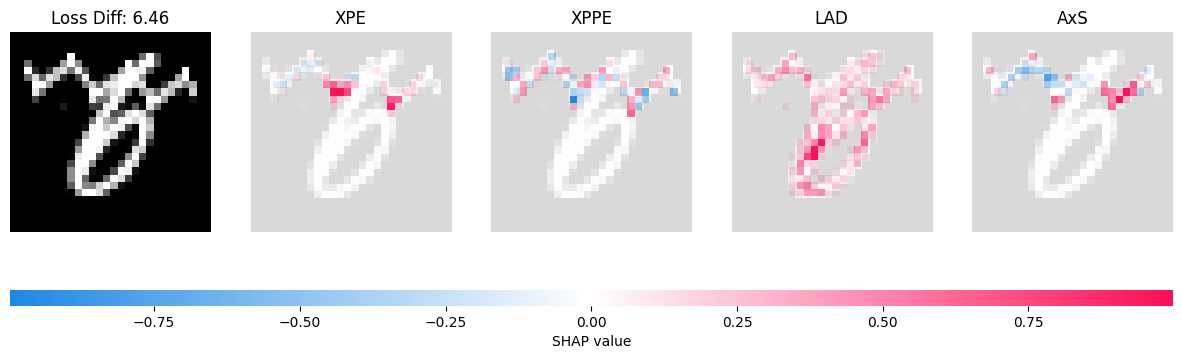

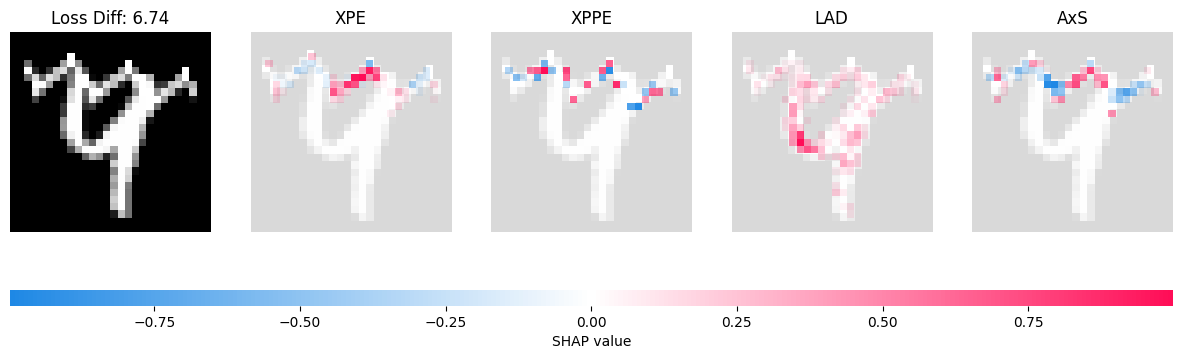

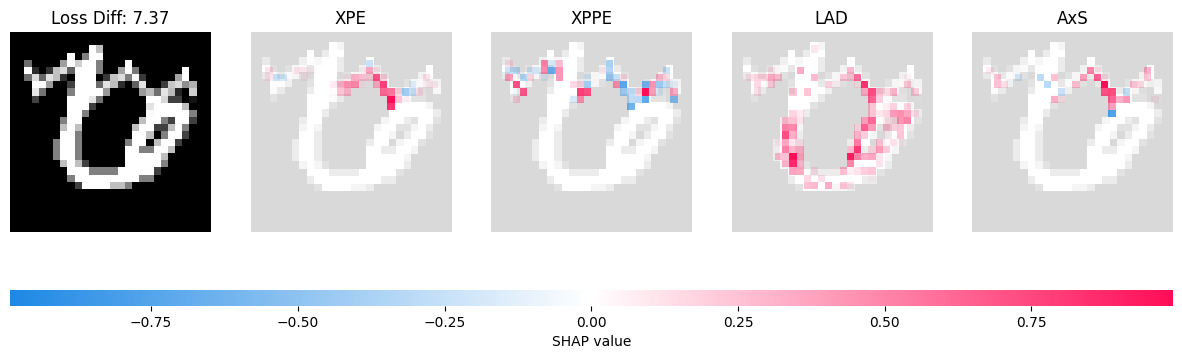

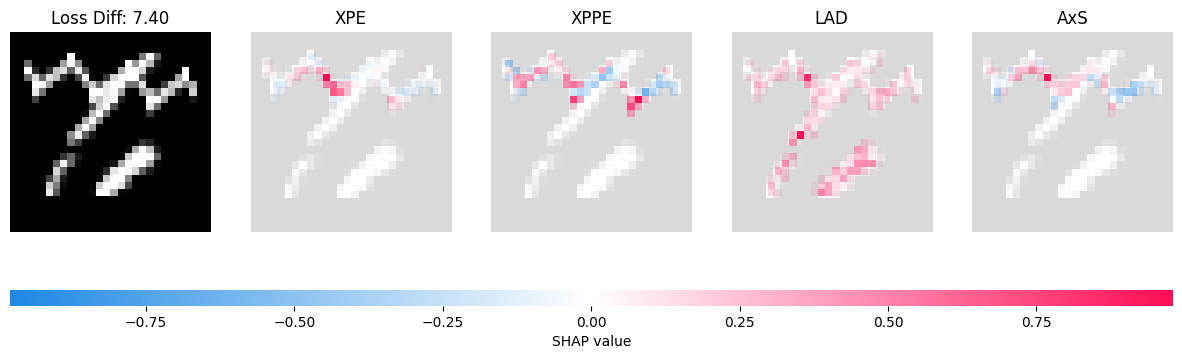

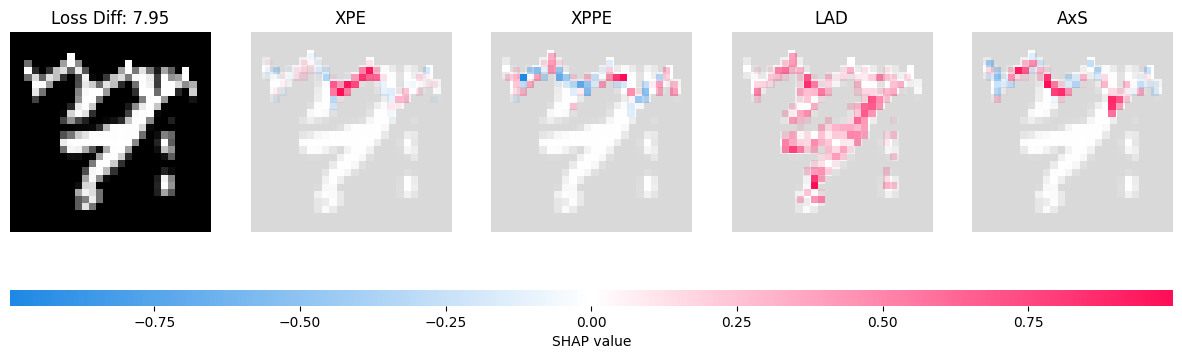

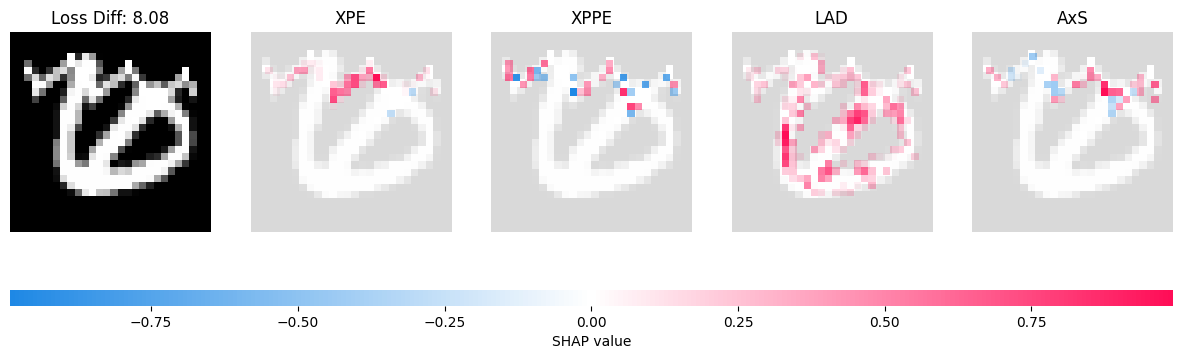

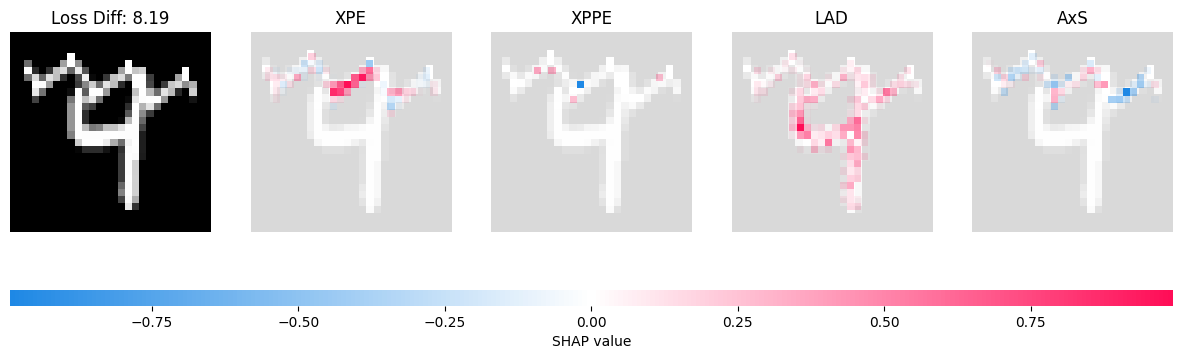

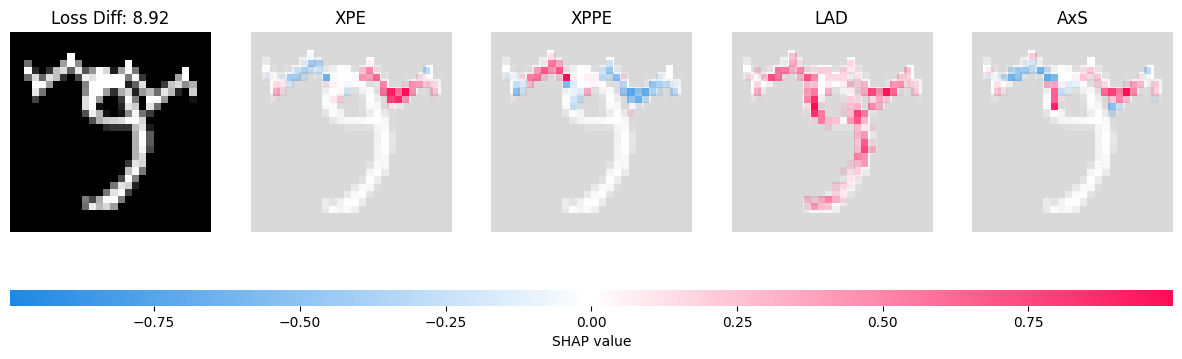

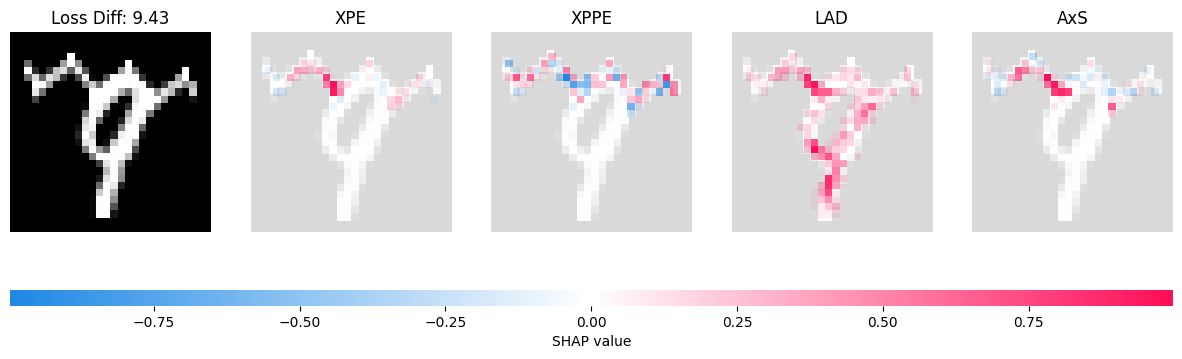

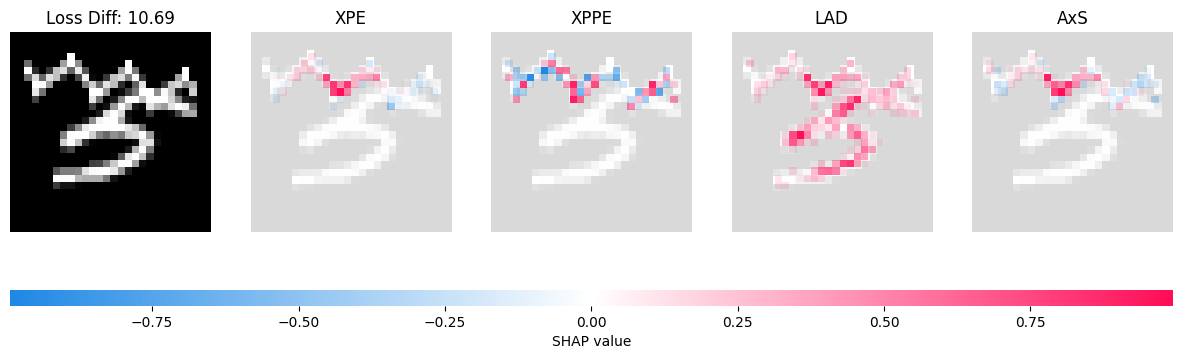

In [4]:
axs = AttributionXShift(model_fn, Xs, Xt, explainer)
lad = LocalAttributionDifference(model_fn, matcher, Xs, Xt, explainer)
xppe = XPPE(model_fn, matcher, Xs, Xt, explainer)
xpe = XPE(model_fn, matcher, Xs, Ys, Xt, explainer)

for i in idx_top:   
   
    result_axs = axs.explain(Xt[i].reshape(1,-1))
    result_axs = normalize_result(result_axs)


    result_lad = lad.explain(Xt[i].reshape(1,-1), i)
    result_lad = normalize_result(result_lad)

    result_xppe = xppe.explain(Xt[i].reshape(1,-1), i)
    result_xppe = normalize_result(result_xppe)


    result_xpe = xpe.explain(Xt[i].reshape(1,-1), i)
    result_xpe = normalize_result(result_xpe)

    result = [result_xpe.reshape(1, 28,28,1), result_xppe.reshape(1,28,28,1), result_lad.reshape(1, 28,28,1), result_axs.reshape(1, 28,28,1)]
   
    shap.image_plot(result, Xt[i].reshape(1,28,28,1), labels=[ "XPE", "XPPE", "LAD", "AxS"], true_labels=[f"Loss Diff: {losses[i]:.2f}"])
